In [32]:
from universeg import universeg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import torch
import math
from skimage import filters
from scipy import ndimage
import random
import torch
import nibabel as nb
import glob

In [2]:
device = 'cpu'
print(device)
model = universeg(pretrained=True).to(device)
# torch.cuda.set_per_process_memory_fraction(0.7, 0)
# import numpy as np
#model

cpu


In [42]:
ids_for_ref = sorted(os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/segmentation_project/med2image"))
print(ids_for_ref)
print(len(ids_for_ref))

ids_for_test = sorted(os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask"))
ids_for_test.pop(0)
to_remove = ['sub-73', 'sub-74', 'sub-75', 'sub-76', 'sub-77']
for item in to_remove:
    if item in ids_for_test:
        ids_for_test.remove(item)
print(ids_for_test)
print(len(ids_for_test))

['sub-9020', 'sub-9021', 'sub-9022']
3
['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40', 'sub-41', 'sub-42', 'sub-43', 'sub-44', 'sub-45', 'sub-46', 'sub-47', 'sub-48', 'sub-49', 'sub-50', 'sub-51', 'sub-52', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-59', 'sub-60', 'sub-61', 'sub-62', 'sub-63', 'sub-64', 'sub-65', 'sub-66', 'sub-67', 'sub-68', 'sub-69', 'sub-70', 'sub-71', 'sub-72', 'sub-78', 'sub-79', 'sub-80', 'sub-81', 'sub-82']
77


In [9]:
# idx = random.sample(range(0, len(ids)-1),1)
# print(idx)

In [21]:
# folder_loc = "/home/neuroimaging/Desktop/Sarvagya_work/segmentation_project/med2image/"
# folder_loc = "/home/neuroimaging/Desktop/Sarvagya_work/segmentation_project/med2image/"
img_folder = "original"
label_folder = "segmented_images"
# test_subs = ids[idx[0]]
# ids.remove(test_subs)
train_subs = ids_for_ref

In [11]:
# train_subs

In [24]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [25]:
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [26]:
support_images = []
support_labels = []
test_images = []
test_labels = []
# min = 12
min = 0
max = 20
folder_loc = "/home/neuroimaging/Desktop/Sarvagya_work/segmentation_project/med2image/"
for i in (os.listdir(folder_loc)):
    print(i)
    if i in train_subs:
        large_sc_images = sorted(os.listdir(folder_loc+i+'/'+img_folder))[min:max]
        for j in (large_sc_images):
            x = mpimg.imread(folder_loc+i+'/'+img_folder+'/'+j)
            x_gray =rgb2gray(x)
            normalized_x_gray = (x_gray-np.min(x_gray))/(np.max(x_gray)-np.min(x_gray))
            normalized_x_gray = torch.tensor(normalized_x_gray, dtype=torch.float32)
            normalized_x_gray = torch.reshape(normalized_x_gray,(1,120,120))
            support_images.append(normalized_x_gray)
        large_sc_labels = sorted(os.listdir(folder_loc+i+'/'+label_folder))[min:max]
        for j in (large_sc_labels):
            x = mpimg.imread(folder_loc+i+'/'+label_folder+'/'+j)
            x = rgb2gray(x)
            threshold = 100
            x = 1.0 * (x > threshold)
            # x = (x-np.min(x))/(np.max(x)-np.min(x))
            x = torch.tensor(x, dtype=torch.float32)
            x = torch.reshape(x, (1,120,120))
            support_labels.append(x)

    # elif i in test_subs:
    #     large_sc_images = sorted(os.listdir(folder_loc+i+'/'+img_folder))[min:max]
    #     for j in (large_sc_images):
    #         x = mpimg.imread(folder_loc+i+'/'+img_folder+'/'+j)
    #         x_gray =rgb2gray(x)
    #         normalized_x_gray = (x_gray-np.min(x_gray))/(np.max(x_gray)-np.min(x_gray))
    #         normalized_x_gray = torch.tensor(normalized_x_gray, dtype=torch.float32)
    #         normalized_x_gray = torch.reshape(normalized_x_gray,(1,120,120))
    #         test_images.append(normalized_x_gray)

    #     large_sc_labels = sorted(os.listdir(folder_loc+i+'/'+label_folder))[min:max]
    #     for j in (large_sc_labels):
    #         x = mpimg.imread(folder_loc+i+'/'+label_folder+'/'+j)
    #         x = rgb2gray(x)
    #         threshold = 100
    #         x = 1.0 * (x > threshold)
    #         # x = (x-np.min(x))/(np.max(x)-np.min(x))
    #         x = torch.tensor(x, dtype=torch.float32)
    #         x = torch.reshape(x, (1,120,120))
    #         test_labels.append(x)

support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)


# test_images = torch.stack(test_images).to(device)
# test_labels = torch.stack(test_labels).to(device)


sub-9021
sub-9020
sub-9022


In [27]:
large_sc_images

['output-slice000.jpg',
 'output-slice001.jpg',
 'output-slice002.jpg',
 'output-slice003.jpg',
 'output-slice004.jpg',
 'output-slice005.jpg',
 'output-slice006.jpg',
 'output-slice007.jpg',
 'output-slice008.jpg',
 'output-slice009.jpg',
 'output-slice010.jpg',
 'output-slice011.jpg',
 'output-slice012.jpg',
 'output-slice013.jpg',
 'output-slice014.jpg',
 'output-slice015.jpg',
 'output-slice016.jpg',
 'output-slice017.jpg',
 'output-slice018.jpg',
 'output-slice019.jpg']

In [28]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

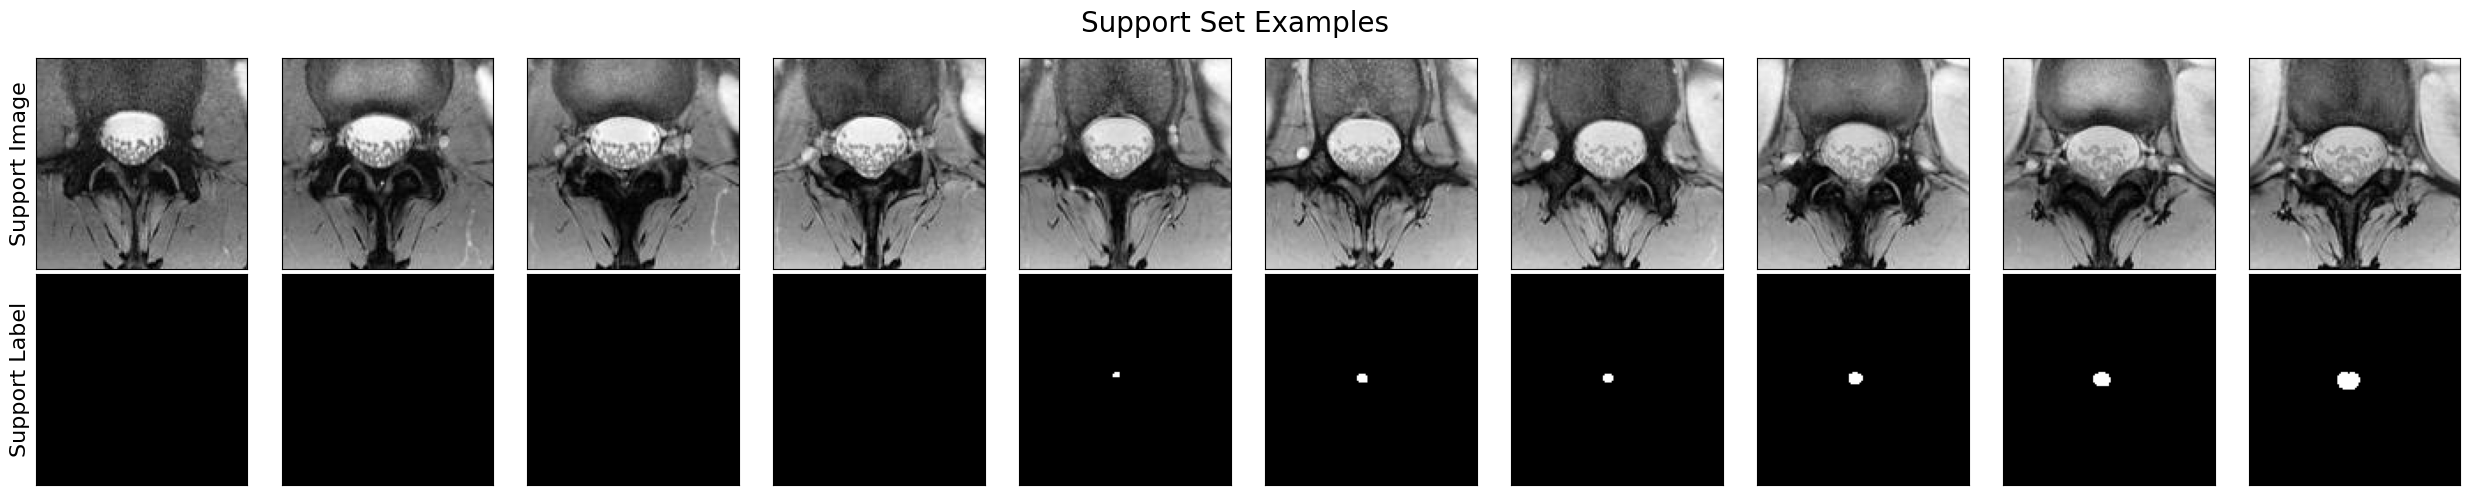

In [29]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

In [63]:
dice_score_inference = np.zeros((47,20))
img_infer = []
label_infer = []
pred_infer = []
count = 0
output_folder = "/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"
for sub in (ids_for_test):
    print(sub)
    sessions = sorted([ses for ses in os.listdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+sub) if "ses-" in ses])
    os.mkdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub)
    for ses in sessions:

        os.mkdir("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses)

        test_images = []
        test_labels = []

        file_ground_truth = glob.glob("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+sub+"/"+ses+"/anat/*desc-crop_seg-manual_label-SC_mask.nii")

        file_sc_images = glob.glob("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/"+sub+"/"+ses+"/anat/*acq-lumbarMEGRE3D_desc-crop_T2starw.nii")

        img_ground_truth = nb.load(file_ground_truth[0])
        img_ground_truth_data = img_ground_truth.get_fdata()

        img_sc_images = nb.load(file_sc_images[0])
        img_sc_images_data = img_sc_images.get_fdata()

        if img_sc_images_data.shape[0]!=120:
             
             pass
        
        else:
            for i in range(img_sc_images_data.shape[2]):
                x_gray = img_sc_images_data[:,:,i]
                x_gray = np.rot90(x_gray)
                # x_gray =rgb2gray(x)
                normalized_x_gray = (x_gray-np.min(x_gray))/(np.max(x_gray)-np.min(x_gray))
                normalized_x_gray = torch.tensor(normalized_x_gray, dtype=torch.float32)
                normalized_x_gray = torch.reshape(normalized_x_gray,(1,x_gray.shape[0],x_gray.shape[1]))
                test_images.append(normalized_x_gray)

            for i in range(img_ground_truth_data.shape[2]):
                x_gray = img_ground_truth_data[:,:,i]
                x_gray = np.rot90(x_gray)
                # x = rgb2gray(x)
                threshold = 100
                x = 1.0 * (x_gray > threshold)
                # x = (x-np.min(x))/(np.max(x)-np.min(x))
                x = torch.tensor(x, dtype=torch.float32)
                x = torch.reshape(x, (1,x_gray.shape[0],x_gray.shape[1]))
                test_labels.append(x)
            
            test_images = torch.stack(test_images).to(device)
            test_labels = torch.stack(test_labels).to(device)

            # idx = np.random.permutation(len(test_images))[0]
            for i in range(len(test_images)):
                image, label = test_images[i], test_labels[i]
                image, label = image.to(device), label.to(device)

            # run inference
                logits = model(image[None], support_images[None], support_labels[None])[0].to(device)
                pred = torch.sigmoid(logits)


                # visualize
                # res = {'data': [image, label, pred, pred > 0.3]}
                # score_dice_hard = dice_score(pred>0.3, label)
                # score_dice_hard = format(score_dice_hard, '.2f')
                # dice_score_inference.append(score_dice_hard)
                # dice_score_inference[count, i] = score_dice_hard
                # titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard) dice score = ' + str(score_dice_hard)]
                # visualize_tensors(res, col_wrap=4, col_names=titles)
                # img_infer.append(image.cpu().detach().numpy().squeeze())
                # label_infer.append(label.cpu().detach().numpy().squeeze())
                # pred_infer.append(pred.cpu().detach().numpy().squeeze())
                # print(pred_out.cpu().detach().numpy().squeeze().shape)
                plt.imsave("/home/neuroimaging/Desktop/Sarvagya_work/GM_mask/segmented_images/"+sub+"/"+ses+"/"+"pred_"+str(f"{i:03}")+".png", pred.cpu().detach().numpy().squeeze())

            # count+=1
# print(count)

sub-01


KeyboardInterrupt: 

In [37]:
dice_score_inference

['0.89',
 '0.89',
 '0.89',
 '0.93',
 '0.89',
 '0.89',
 '0.89',
 '0.89',
 '0.93',
 '0.89',
 '0.90',
 '0.89',
 '0.89',
 '0.89',
 '0.88']

In [38]:
for i in range(len(dice_score_inference)):
    if dice_score_inference[i]=='nan':
        dice_score_inference[i]=float(1)
    else:
        dice_score_inference[i] = float(dice_score_inference[i])
print(dice_score_inference)

[0.89, 0.89, 0.89, 0.93, 0.89, 0.89, 0.89, 0.89, 0.93, 0.89, 0.9, 0.89, 0.89, 0.89, 0.88]


In [39]:
np.average(dice_score_inference)

np.float64(0.8953333333333335)

6


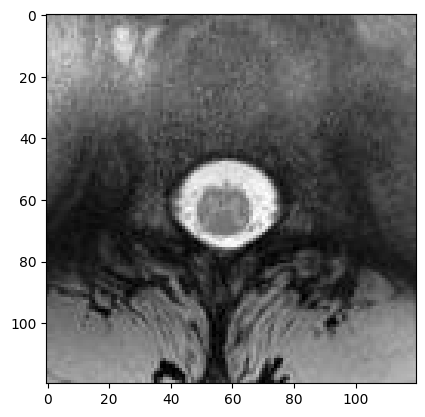

In [40]:
idx = random.sample(range(0, 14),1)
print(idx[0])
idx[0]=3
plt.imshow(img_infer[idx[0]], cmap='gray')
plt.show()

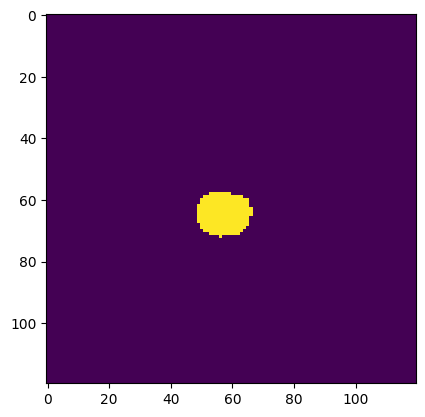

In [41]:
plt.imshow(pred_infer[idx[0]]>0.3)
plt.show()

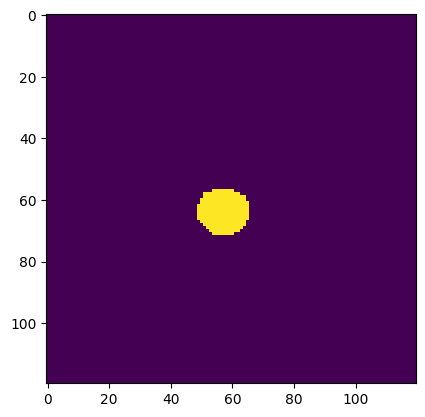

In [42]:
plt.imshow(label_infer[idx[0]])
plt.show()

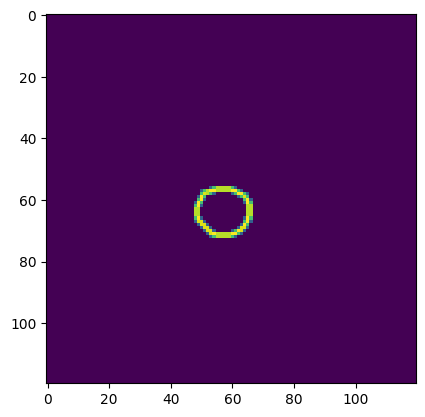

In [43]:
# label = label.detach().numpy().squeeze()
# pred = pred.detach().numpy().squeeze()
edge_sobel_label = filters.sobel(label_infer[idx[0]])
edge_sobel_pred = filters.sobel(pred_infer[idx[0]] > 0.3)
plt.imshow(edge_sobel_label)
plt.show()

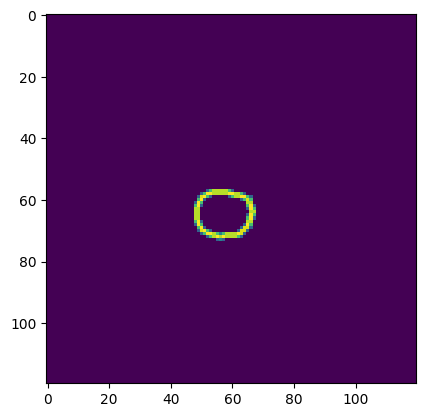

In [44]:
plt.imshow(edge_sobel_pred)
plt.show()

In [45]:
# image = image.detach().numpy().squeeze()
image_my_pred = np.copy(img_infer[idx[0]])
image_ground_truth = np.copy(img_infer[idx[0]])
print(image_my_pred.shape)
image_my_pred[np.where(edge_sobel_pred > 0.3)] = 0
image_ground_truth[np.where(edge_sobel_label)] = 0

(120, 120)


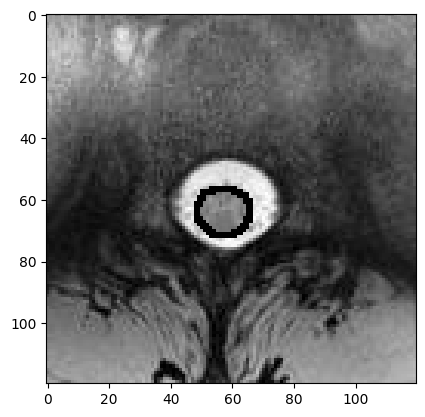

In [46]:
plt.imshow(image_ground_truth, cmap='gray')
plt.savefig("/home/neuroimaging/Desktop/Sarvagya_work/segmentation_project/presentation_images/gt_8.png")
plt.show()

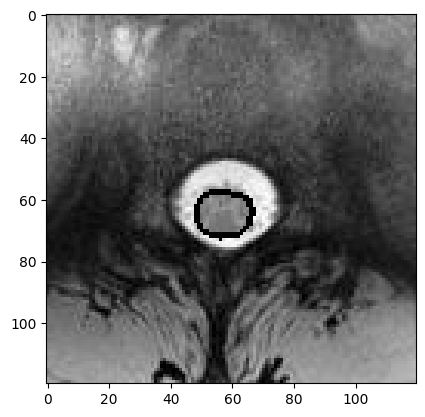

In [47]:
plt.imshow(image_my_pred, cmap='gray')
plt.savefig("/home/neuroimaging/Desktop/Sarvagya_work/segmentation_project/presentation_images/seg_8.png")
plt.show()